# Benchmark SGD Implementations  
In this iPython notebook, we benchmark the Parallel implementaton of SGD against the implementation in SciKit-Learn library. We will use SGD in both cases for regression on synthetic data.   

**Credits**  
The parallel implementation here is based on this paper: Zinkevich, M., Weimer, M., Li, L., & Smola, A. (2010). Parallelized stochastic gradient descent. Advances in Neural …, 1–36. Retrieved from http://papers.nips.cc/paper/4006-parallelized-stochastic-gradient-descent 

## The Dataset  
The dataset will be generated using SciKit-Learn's `make_regression` function.  

In [1]:
from sklearn.datasets import make_regression
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
n_samples = 1000
n_features = 100
seed = 1

In [3]:
X, y = make_regression(n_samples=n_samples, n_features=n_features, random_state=seed, noise=1.0, effective_rank=100)

Split the dataset into train and test

In [4]:
from sklearn.cross_validation import ShuffleSplit

In [5]:
for train, test in ShuffleSplit(n=n_samples, n_iter=1, test_size=0.2):
    pass

In [6]:
X_train = X[train]
X_test = X[test]
y_train = y[train]
y_test = y[test]

## SciKit-Learn SGD

In [7]:
from sklearn.linear_model import SGDRegressor

In [8]:
n_iter = 10000

In [9]:
sgd = SGDRegressor(n_iter=n_iter)

In [10]:
%time sgd.fit(X_train, y_train)

CPU times: user 2.32 s, sys: 17.6 ms, total: 2.34 s
Wall time: 2.34 s


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=10000, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [11]:
sgd.score(X_test, y_test)

0.84561337824816829

In [12]:
scores = []
sgd = SGDRegressor(n_iter=1, warm_start=True)
for i in range(n_iter):
    sgd.partial_fit(X_train, y_train)
    scores += [sgd.score(X_test, y_test)]

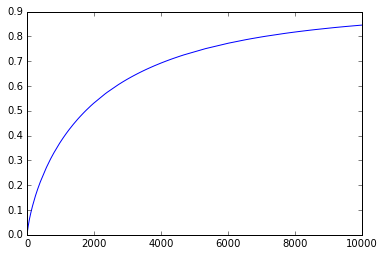

In [13]:
plt.plot(range(len(scores)), scores)

In [14]:
scores[-1]

0.84560025088240121

##  Parallel SGD Simulation
We run multiple simulations of Parallel SGD to 

In [58]:
import utils
reload(utils)

<module 'utils' from 'utils.py'>

### Test 1: Split data evenly, synchronize at the end
Simulate running SGD in parallel such that the input data is split evenly amongst the workers. The weights are synchronized once after all workers are done.

In [50]:
n_jobs = 4
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)

CPU times: user 40.4 s, sys: 2min 45s, total: 3min 26s
Wall time: 26.2 s


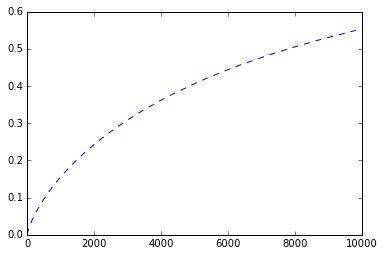

In [51]:
utils.plot_scores(scores)

### Test 2: Don't Split data, synchronize at the end
Simulate running SGD in parallel such that all workers have access to all the data. The weights are synchronized once after all workers are done.


In [52]:
n_jobs = 4
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True)

CPU times: user 1min 4s, sys: 4min 27s, total: 5min 31s
Wall time: 42.6 s


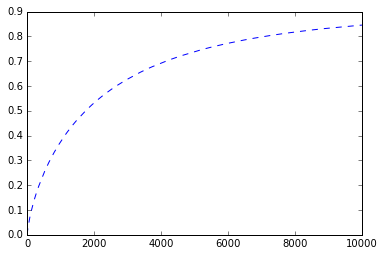

In [53]:
utils.plot_scores(scores)

### Test 3: Split data with overlap, synchronize at the end

Each machine has 50% of all data

In [54]:
n_jobs = 4
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.5, overlap=True)

CPU times: user 49.3 s, sys: 3min 25s, total: 4min 14s
Wall time: 32.6 s


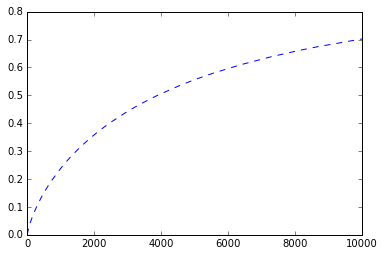

In [55]:
utils.plot_scores(scores)

Each machine has 25% of all data

In [56]:
n_jobs = 4
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.25, overlap=True)

CPU times: user 42.5 s, sys: 3min 1s, total: 3min 44s
Wall time: 29.1 s


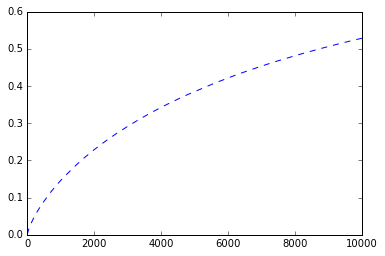

In [57]:
utils.plot_scores(scores)

### Test 4: Split data with overlap, synchronize 2 times
**Pending**

### Trial parallel SGD

In [59]:
from multiprocessing import Pool

In [60]:
import numpy as np

In [61]:
n_jobs = 4

In [62]:
pool = Pool(processes=n_jobs)

In [63]:
%time sgd_p = utils.parallel_sgd(SGDRegressor(), pool, X_train, y_train, n_iter, n_jobs)

Spliting data...
Executing in parallel...
Combining results...
CPU times: user 7.75 ms, sys: 0 ns, total: 7.75 ms
Wall time: 623 ms


In [64]:
sgd_p.score(X_test, y_test)

0.55335762776760822